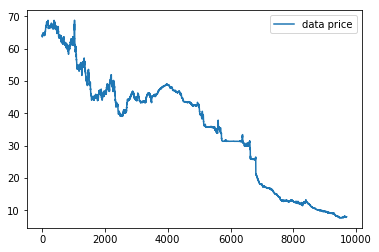

In [28]:
# Data: time-serie data from smartwatch or smartwatch data
# %matplotlib inline # for plt.show()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data reading
# The smartwatch historical/time-seris data to visualize
# data_path = 'data/smartwatch_data/experimental_data_analysis/Basis_Watch_Data.csv'
data_path = 'data/financial_data/USD_INR.csv'
data = pd.read_csv(data_path)

# # Data: cleaning
# # Getting rid of NaN
# data = data.fillna(value=0.0)

# # # # Plotting the smartwatch data before scaling/batch normalization
# # data[:10000]['Price'].plot() #x='dteday', y='cnt'
# data[:3].plot()
# plt.legend()
# plt.show()

# # # data[:100].plot()
# np.array(data).shape, np.array(data).dtype, np.array(data, dtype=None).dtype, 
# np.array(data[:, 1:], dtype=None).dtype

data_price = np.array(data['Price'], dtype=float)
# data_price = np.array(data)
data_price.shape, data_price.dtype

plt.plot(data_price, label='data price')
plt.legend()
plt.show()

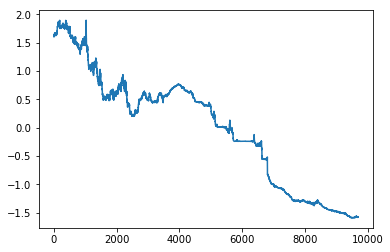

(4.6895674011185329e-17, 1.0, 1.0, (9697,), dtype('float64'))

In [29]:
# test_data = np.array([[1, 2, 3]], dtype=float)
# test_data.shape, test_data.dtype
# np.mean(test_data, axis=0), test_data

# data_ = np.array(data[:, 1], dtype=float)
# data_.shape, data_.dtype
data_mean = np.mean(data_price, axis=0)
data_std = np.std(data_price, axis=0)
# std, mean, np.sqrt(np.var(data_price))
# data_norm = (data_price - mean) / std
# data_norm.dtype, data_norm.shape

# plt.plot(data_norm, label='data price norm')
# # plt.plot(data_price[:10000], label='data price')
# plt.legend()
# plt.show()

data_price_norm = (data_price - data_mean) / data_std
plt.plot(data_price_norm)
plt.show()
data_price_norm.mean(), data_price_norm.std(), data_price_norm.var(), data_price_norm.shape, data_price_norm.dtype

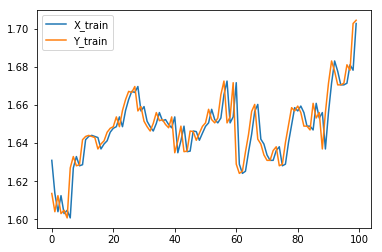

In [30]:
train_data = data_price_norm[:9000]
test_data = data_price_norm[9000:]
train_data.shape, test_data.shape
X_train = train_data[0:8999]
Y_train = train_data[1:9000]
X_train.shape, Y_train.shape

plt.plot(X_train[:100], label='X_train')
plt.plot(Y_train[:100], label='Y_train')
plt.legend()
plt.show()

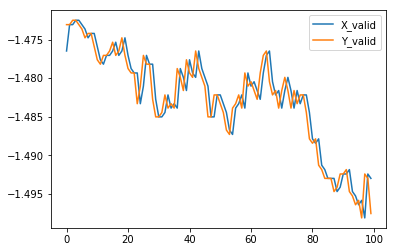

In [31]:
X_valid = test_data[0:696] 
Y_valid = test_data[1:697]
X_valid.shape, Y_valid.shape
plt.plot(X_valid[:100], label='X_valid')
plt.plot(Y_valid[:100], label='Y_valid')
plt.legend()
plt.show()

In [35]:
# Model or Network
import impl.layer as l
from impl.loss import *

class GRU:
    def __init__(self, D, H):
        self.D = D
        self.H = H
        self.losses = {'train':[], 'smooth train':[], 'valid': []}
        
        # Model params
        Z = H + D
        m = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wr=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(H / 2.),
            bz=np.zeros((1, H)),
            br=np.zeros((1, H)),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
        )
        self.model = m
        
    def initial_state(self):
        return np.zeros((1, self.H))

    def forward(self, X, h, m):
        Wz, Wr, Wh, Wy = m['Wz'], m['Wr'], m['Wh'], m['Wy']
        bz, br, bh, by = m['bz'], m['br'], m['bh'], m['by']

        X_in = X.copy()
        h_in = h.copy()

        X = np.column_stack((h_in, X_in))

        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)

        hr, hr_cache = l.fc_forward(X, Wr, br)
        hr, hr_sigm_cache = l.sigmoid_forward(hr)

        X = np.column_stack((hr * h_in, X_in))
        
        hh, hh_cache = l.fc_forward(X, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        # h = (1. - hz) * h_old + hz * hh
        # or
        h = ((1. - hz) * h_in) + (hz * hh)
        # or
        # h = h_in + hz (hh - h_in)

        y, y_cache = l.fc_forward(h, Wy, by)
        
        cache = (h_in, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, 
                 y_cache)

        return y, h, cache

    def backward(self, dy, dh, cache):
        h_in, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache = cache
        
        dh_out = dh.copy()

        dh, dWy, dby = l.fc_backward(dy, y_cache)
        dh += dh_out

        dh_in1 = (1. - hz) * dh
        dhh = hz * dh
        dhz = (hh * dh) - (h_in * dh)
        # or
        # dhz = (hh - h_in) * dh

        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dXh, dWh, dbh = l.fc_backward(dhh, hh_cache)

        dh = dXh[:, :self.H]
        dX_in2 = dXh[:, self.H:]
        dh_in2 = hr * dh

        dhr = h_in * dh
        dhr = l.sigmoid_backward(dhr, hr_sigm_cache)
        dXr, dWr, dbr = l.fc_backward(dhr, hr_cache)

        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dXz, dWz, dbz = l.fc_backward(dhz, hz_cache)

        dX = dXr + dXz
        dh_in3 = dX[:, :self.H]
        dX_in1 = dX[:, self.H:]

        dh = dh_in1 + dh_in2 + dh_in3
        dX = dX_in1 + dX_in2

        grad = dict(Wz=dWz, Wr=dWr, Wh=dWh, Wy=dWy, bz=dbz, br=dbr, bh=dbh, by=dby)
        
        return dX, dh, grad

    def train_forward(self, X_train, h):
        ys, caches = [], []

        for X in X_train:
            X = X.reshape(1, -1) # X_1xn
            y, h, cache = self.forward(X, h, self.model)
            caches.append(cache)
            ys.append(y)
        
        ys = np.array(ys, dtype=float).reshape(len(ys), -1) # ys_txn instead of ys_tx1xn
        
        return ys, caches
                                
    def loss_function(self, y_pred, y_train): # , alpha alpha: learning rate
        loss, dys = 0.0, []

        for y, Y in zip(y_pred, y_train):
            #             loss += l2_regression(y_pred=y, y_train=Y)
            #             dy = dl2_regression(y_pred=y, y_train=Y)
            loss += l2_regression_reg(model=self.model, y_pred=y, y_train=Y) #, lam=alpha
            dy = dl2_regression_reg(y_pred=y, y_train=Y)
            #             loss += l1_regression_reg(model=self.model, y_pred=y, y_train=Y) #, lam=alpha
            #             dy = dl1_regression_reg(y_pred=y, y_train=Y)
            dys.append(dy)
            
        return loss, dys
    
    def train_backward(self, dys, caches):
        dh=(np.zeros((1, self.H)))
        grad=({key: np.zeros_like(val) for key, val in self.model.items()})
        grads=({key: np.zeros_like(val) for key, val in self.model.items()})

        for t in reversed(range(len(dys))):
            dy = dys[t].reshape(1, -1) # dy_1xn
            dX, dh, grad = self.backward(dy, dh, caches[t])
            for key in grad.keys():
                grads[key] += grad[key]
                
        return grads
    
    def test(self, X_seed, h, size):
        ys = []
        X = X_seed.reshape(1, -1)
        for _ in range(size):
            y, h, _ = self.forward(X, h, self.model)
            X = y.copy() # previous out for the next input for prediction
            ys.append(y) # list array
        
        ys = np.array(ys, dtype=float).reshape(len(ys), -1) # ys_txn instead of ys_tx1xn
        return ys

In [36]:
def get_minibatch(X, y, minibatch_size, shuffle):
    minibatches = []

    for i in range(0, X.shape[0], minibatch_size):
    # for i in range(0, X.shape[0] - minibatch_size + 1, 1):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]
        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, XY_train, alpha, mb_size, n_iter, print_after, XY_valid):
    X_train, y_train = XY_train
    X_valid, y_valid = XY_valid

    M=({key: np.zeros_like(val) for key, val in nn.model.items()})
    R=({key: np.zeros_like(val) for key, val in nn.model.items()})
        
    beta1 = .99
    beta2 = .999
    state = nn.initial_state()
    smooth_loss = 1.
    minibatches = get_minibatch(X_train, y_train, mb_size, shuffle=False)
    
    for iter in range(1, n_iter + 1):
        for idx in range(len(minibatches)):
            # Train model
            X_mini, y_mini = minibatches[idx]
            ys, caches = nn.train_forward(X_mini, state)
            loss, dys = nn.loss_function(y_pred=ys, y_train=y_mini) #, alpha=alpha
            grads = nn.train_backward(dys, caches)
            nn.losses['train'].append(loss)
            smooth_loss = (0.999 * smooth_loss) + (0.001 * loss)
            nn.losses['smooth train'].append(smooth_loss)
            
            # Update model
            for k in grads.keys(): #key, value: items
                M[k] = l.exp_running_avg(M[k], grads[k], beta1)
                R[k] = l.exp_running_avg(R[k], grads[k]**2, beta2)
                m_k_hat = M[k] / (1. - (beta1**(iter)))
                r_k_hat = R[k] / (1. - (beta2**(iter)))
                nn.model[k] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)

            # Validate/test model
            # Validation loss to avoid overfitting & underfitting
            # Prediction or predicted sequence
            ys = nn.test(X_seed=X_valid[0], h=state, size=X_valid.shape[0]) # ys_tx1xn
            valid_loss, _ = nn.loss_function(y_pred=ys, y_train=Y_valid) #, alpha=alpha
            nn.losses['valid'].append(valid_loss)

        # Print model loss/ error
        if iter % print_after == 0:
            print('Iter-{}, train loss: {:.8f}, valid loss: {:.8f}'.format(iter, loss, valid_loss))

    return nn

In [34]:
# Hyper-parameters
time_step = 100 # minibatch size
n_iter = 1000 # epochs
alpha = 1e-4 # learning_rate
print_after = 1 # print training loss, valid, and test
num_hidden_units = 4 # num_hidden_units in hidden layer
num_input_units = 1

# Build the network and learning it or optimizing it using SGD
net = GRU(D=num_input_units, H=num_hidden_units) #, L=num_layers, p_dropout=p_dropout

# Start learning using BP-SGD-ADAM
adam_rnn(nn=net, XY_train=(X_train, Y_train), alpha=alpha, mb_size=time_step, n_iter=n_iter,
         print_after=print_after, XY_valid=(X_valid, Y_valid))

Iter-1, train loss: 42.77240066, valid loss: 1241.36005383
Iter-2, train loss: 29.73863671, valid loss: 1571.57079984
Iter-3, train loss: 21.35048124, valid loss: 1734.99141026
Iter-4, train loss: 16.24339819, valid loss: 170.56965023
Iter-5, train loss: 13.09949838, valid loss: 111.28885274
Iter-6, train loss: 11.10228444, valid loss: 82.93419296
Iter-7, train loss: 9.78286997, valid loss: 67.17064074
Iter-8, train loss: 8.87425958, valid loss: 57.57327705
Iter-9, train loss: 8.22230889, valid loss: 51.32453121
Iter-10, train loss: 7.73601409, valid loss: 47.03197579
Iter-11, train loss: 7.36024090, valid loss: 43.94984088
Iter-12, train loss: 7.06065548, valid loss: 41.65362321
Iter-13, train loss: 6.81526187, valid loss: 39.88937714
Iter-14, train loss: 6.60955809, valid loss: 38.49855625
Iter-15, train loss: 6.43370731, valid loss: 37.37834850
Iter-16, train loss: 6.28085141, valid loss: 36.45976680
Iter-17, train loss: 6.14608370, valid loss: 35.69507137
Iter-18, train loss: 6.025

Iter-144, train loss: 2.63983552, valid loss: 30.62799942
Iter-145, train loss: 2.62722880, valid loss: 30.59716743
Iter-146, train loss: 2.61473967, valid loss: 30.56627732
Iter-147, train loss: 2.60236907, valid loss: 30.53540233
Iter-148, train loss: 2.59011785, valid loss: 30.50461294
Iter-149, train loss: 2.57798668, valid loss: 30.47397659
Iter-150, train loss: 2.56597608, valid loss: 30.44355737
Iter-151, train loss: 2.55408641, valid loss: 30.41341591
Iter-152, train loss: 2.54231790, valid loss: 30.38360915
Iter-153, train loss: 2.53067062, valid loss: 30.35419026
Iter-154, train loss: 2.51914450, valid loss: 30.32520855
Iter-155, train loss: 2.50773933, valid loss: 30.29670948
Iter-156, train loss: 2.49645478, valid loss: 30.26873463
Iter-157, train loss: 2.48529038, valid loss: 30.24132173
Iter-158, train loss: 2.47424556, valid loss: 30.21450478
Iter-159, train loss: 2.46331962, valid loss: 30.18831407
Iter-160, train loss: 2.45251178, valid loss: 30.16277634
Iter-161, trai

Iter-286, train loss: 1.66923585, valid loss: 30.32132380
Iter-287, train loss: 1.66579271, valid loss: 30.33193161
Iter-288, train loss: 1.66237838, valid loss: 30.34258582
Iter-289, train loss: 1.65899264, valid loss: 30.35328618
Iter-290, train loss: 1.65563528, valid loss: 30.36403241
Iter-291, train loss: 1.65230610, valid loss: 30.37482424
Iter-292, train loss: 1.64900489, valid loss: 30.38566138
Iter-293, train loss: 1.64573144, valid loss: 30.39654352
Iter-294, train loss: 1.64248554, valid loss: 30.40747036
Iter-295, train loss: 1.63926699, valid loss: 30.41844158
Iter-296, train loss: 1.63607558, valid loss: 30.42945683
Iter-297, train loss: 1.63291109, valid loss: 30.44051575
Iter-298, train loss: 1.62977334, valid loss: 30.45161797
Iter-299, train loss: 1.62666210, valid loss: 30.46276311
Iter-300, train loss: 1.62357716, valid loss: 30.47395073
Iter-301, train loss: 1.62051833, valid loss: 30.48518041
Iter-302, train loss: 1.61748538, valid loss: 30.49645169
Iter-303, trai

Iter-428, train loss: 1.37286258, valid loss: 31.73741736
Iter-429, train loss: 1.37159275, valid loss: 31.74013519
Iter-430, train loss: 1.37033072, valid loss: 31.74267038
Iter-431, train loss: 1.36907652, valid loss: 31.74502303
Iter-432, train loss: 1.36783017, valid loss: 31.74719330
Iter-433, train loss: 1.36659167, valid loss: 31.74918142
Iter-434, train loss: 1.36536105, valid loss: 31.75098771
Iter-435, train loss: 1.36413832, valid loss: 31.75261252
Iter-436, train loss: 1.36292349, valid loss: 31.75405631
Iter-437, train loss: 1.36171659, valid loss: 31.75531958
Iter-438, train loss: 1.36051763, valid loss: 31.75640290
Iter-439, train loss: 1.35932661, valid loss: 31.75730688
Iter-440, train loss: 1.35814355, valid loss: 31.75803223
Iter-441, train loss: 1.35696845, valid loss: 31.75857966
Iter-442, train loss: 1.35580133, valid loss: 31.75894999
Iter-443, train loss: 1.35464220, valid loss: 31.75914404
Iter-444, train loss: 1.35349105, valid loss: 31.75916272
Iter-445, trai

Iter-570, train loss: 1.26889187, valid loss: 30.74790284
Iter-571, train loss: 1.26867494, valid loss: 30.73444644
Iter-572, train loss: 1.26846472, valid loss: 30.72093725
Iter-573, train loss: 1.26826119, valid loss: 30.70737595
Iter-574, train loss: 1.26806434, valid loss: 30.69376320
Iter-575, train loss: 1.26787413, valid loss: 30.68009965
Iter-576, train loss: 1.26769055, valid loss: 30.66638598
Iter-577, train loss: 1.26751358, valid loss: 30.65262283
Iter-578, train loss: 1.26734319, valid loss: 30.63881088
Iter-579, train loss: 1.26717937, valid loss: 30.62495078
Iter-580, train loss: 1.26702209, valid loss: 30.61104320
Iter-581, train loss: 1.26687132, valid loss: 30.59708879
Iter-582, train loss: 1.26672705, valid loss: 30.58308823
Iter-583, train loss: 1.26658925, valid loss: 30.56904217
Iter-584, train loss: 1.26645789, valid loss: 30.55495127
Iter-585, train loss: 1.26633295, valid loss: 30.54081621
Iter-586, train loss: 1.26621440, valid loss: 30.52663763
Iter-587, trai

Iter-712, train loss: 1.28749404, valid loss: 28.61789005
Iter-713, train loss: 1.28779323, valid loss: 28.60338029
Iter-714, train loss: 1.28809172, valid loss: 28.58889941
Iter-715, train loss: 1.28838947, valid loss: 28.57444762
Iter-716, train loss: 1.28868642, valid loss: 28.56002514
Iter-717, train loss: 1.28898250, valid loss: 28.54563217
Iter-718, train loss: 1.28927767, valid loss: 28.53126888
Iter-719, train loss: 1.28957186, valid loss: 28.51693548
Iter-720, train loss: 1.28986503, valid loss: 28.50263213
Iter-721, train loss: 1.29015710, valid loss: 28.48835900
Iter-722, train loss: 1.29044804, valid loss: 28.47411625
Iter-723, train loss: 1.29073779, valid loss: 28.45990404
Iter-724, train loss: 1.29102629, valid loss: 28.44572250
Iter-725, train loss: 1.29131349, valid loss: 28.43157178
Iter-726, train loss: 1.29159935, valid loss: 28.41745200
Iter-727, train loss: 1.29188380, valid loss: 28.40336328
Iter-728, train loss: 1.29216680, valid loss: 28.38930575
Iter-729, trai

Iter-854, train loss: 1.30588537, valid loss: 26.84644340
Iter-855, train loss: 1.30577970, valid loss: 26.83555140
Iter-856, train loss: 1.30567045, valid loss: 26.82467160
Iter-857, train loss: 1.30555760, valid loss: 26.81380379
Iter-858, train loss: 1.30544116, valid loss: 26.80294779
Iter-859, train loss: 1.30532113, valid loss: 26.79210338
Iter-860, train loss: 1.30519752, valid loss: 26.78127039
Iter-861, train loss: 1.30507032, valid loss: 26.77044862
Iter-862, train loss: 1.30493953, valid loss: 26.75963789
Iter-863, train loss: 1.30480517, valid loss: 26.74883800
Iter-864, train loss: 1.30466722, valid loss: 26.73804878
Iter-865, train loss: 1.30452568, valid loss: 26.72727004
Iter-866, train loss: 1.30438057, valid loss: 26.71650162
Iter-867, train loss: 1.30423189, valid loss: 26.70574332
Iter-868, train loss: 1.30407963, valid loss: 26.69499499
Iter-869, train loss: 1.30392379, valid loss: 26.68425644
Iter-870, train loss: 1.30376439, valid loss: 26.67352752
Iter-871, trai

Iter-996, train loss: 1.25737890, valid loss: 25.38405396
Iter-997, train loss: 1.25683467, valid loss: 25.37457004
Iter-998, train loss: 1.25628846, valid loss: 25.36510738
Iter-999, train loss: 1.25574028, valid loss: 25.35566633
Iter-1000, train loss: 1.25519017, valid loss: 25.34624719


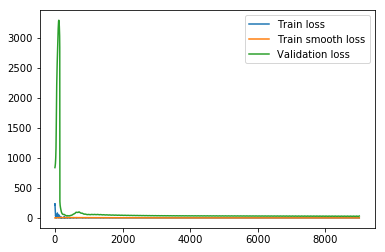

In [26]:
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.plot(net.losses['valid'], label='Validation loss')
plt.legend()
plt.show()

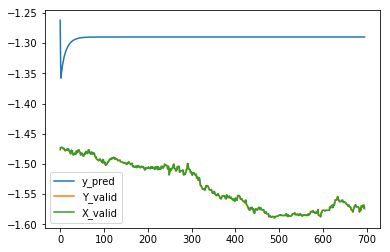

In [27]:
import matplotlib.pyplot as plt

y_pred = net.test(X_seed=X_valid[0], h=net.initial_state(), size=X_valid.shape[0]) # ys_tx1xn
y_pred.shape, Y_valid.shape

plt.plot(y_pred, label='y_pred')
plt.plot(Y_valid, label='Y_valid')
plt.plot(X_valid, label='X_valid')
plt.legend()
plt.show()